In [34]:
import cv2
import logging as log
import numpy as np
import queue
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os

**Focus Method Comparison**

Comparing Laplacian and Normalized Variance algos for choosing in focus image across a variety of core samples. Will also be testing the viability of selecting regions of interest as proxy for whole image focus.

**NOTES**

Based on testing on a variety of images across a cookie sample, normalized variance scoring seems to be much more accurate when compared with laplacian scores.
This is in line with research on microscopy focus scoring (Yu Sun et al., Mir et al.).
'Best' images used for this comparison were chosen manually.  

In [64]:
dir = "./stack_test"
image_folders = os.listdir("./stack_test")

all_images= {}
best_images = {}
lap_best = {}
var_best = {}
for folder in image_folders:
    image_filenames = os.listdir("{}/{}".format(dir, folder))
    arr_name = f"{folder}_array"
    all_images[arr_name] = []
    best_images[arr_name] = []
    lap_best[arr_name] = []
    var_best[arr_name] = []
    for image in image_filenames:
        if image == "best.tiff":
            best_images[arr_name] = plt.imread("{}/{}/{}".format(dir, folder, image))
        all_images[arr_name].append(plt.imread("{}/{}/{}".format(dir, folder, image)))

Functions for computing focus scores

In [69]:
def compute_laplacian(image):

    # odd numbers only, can be tuned
    kernel_size = 11         # Size of the laplacian window
    blur_size = 9           # How big of a kernel to use for the gaussian blur

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size) 

def best_focused_image_laplacian(images):
    best_image = []
    best_lap = 0.0
    for image in images:
        lap = compute_laplacian(image)
        if lap.var() > best_lap:
            best_lap = lap.var()
            best_image = image
    return best_image

In [106]:
def compute_variance(image):
    # adapted from macro info at https://imagejdocu.list.lu/macro/normalized_variance
    mean = np.mean(image, axis=(0,1))
    width, height,_ = image.shape
    square_diff = (image - mean)**2
    b = np.sum(square_diff)
    normVar = b/(height * width * mean)
    return normVar

def best_focused_image_variance(images):
    best_image = []
    best_var = np.array([0,0,0])

    for image in images:
        var = compute_variance(image)
        if var.all() > best_var.all():
            best_image = image
            best_var = var

    return best_image

In [78]:
compute_variance(best_images['border1_array'])

[1.95296472 3.07962177 3.78581475]


array([1.95296472, 3.07962177, 3.78581475])

Compute focus scores for the entire image

In [108]:
for array in all_images:
    lap_best[array] = best_focused_image_laplacian(all_images[array])
    var_best[array] = best_focused_image_variance(all_images[array])

In [107]:
var_best['edge2_array'] = best_focused_image_variance(all_images['edge2_array'])


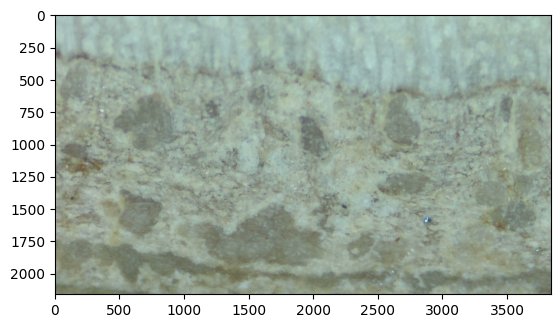

In [49]:
testshow = plt.imread('./stack_test/edge1/best.tiff')
#plt.imshow(testshow)

plt.imshow(best_images["border1_array"])

In [110]:
for arr in lap_best:
    print(not np.any(cv2.subtract(lap_best[arr], best_images[arr])))

False
False
False
True
False
True


In [111]:
for arr in var_best:
    print(not np.any(cv2.subtract(var_best[arr], best_images[arr])))

True
True
True
True
True
True
